In [1]:
import spice
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

PROPOSER_ADDRESS = '0x473300df21D047806A082244b417f96b32f13A33'
BATCHER_ADDRESS = '0x6887246668a3b87F54DeB3b94Ba47a6f63F32985'
TIME_INTERVAL = '2'
TRAILING_DAYS = '365'

## Proposer


In [2]:
proposer_df = spice.query(5939705, parameters={
    'Address': PROPOSER_ADDRESS,
    'Time Interval': TIME_INTERVAL,
    'Trailing Days': TRAILING_DAYS
}, performance="large")

getting results, query_id = 5939705
saving result to cache


In [3]:
proposer_df = proposer_df.with_columns(
    pl.col("block_date").str.to_date().alias("block_date")
)

In [4]:
proposer_df = proposer_df.with_columns(
    (
        pl.col("max_gas_price_in_gwei") / 1e9 * pl.col("max_gas_used") * pl.col("total_txs")
    ).alias("transaction_fee_in_eth_extreme")
)

proposer_df = proposer_df.with_columns(
    (
        pl.col("pct99_gas_price_in_gwei") / 1e9 * pl.col("pct99_gas_used") * pl.col("total_txs")
    ).alias("transaction_fee_in_eth_pct99")
)

In [5]:
proposer_df.describe()

statistic,block_date,daily_transaction_fee_in_eth,daily_blob_fee_in_eth,daily_all_fees_in_eth,total_transaction_fee_in_eth,total_blob_fee_in_eth,total_all_fees,total_value_in_eth,total_txs,avg_seconds_between_txs,avg_gas_price_in_gwei,max_gas_price_in_gwei,pct99_gas_price_in_gwei,avg_gas_used,max_gas_used,pct99_gas_used,avg_blob_base_fee,max_blob_base_fee,pct99_blob_base_fee,avg_blob_gas_used,max_blob_gas_used,pct99_blob_gas_used,transaction_fee_in_eth_extreme,transaction_fee_in_eth_pct99
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""364""",364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2025-04-10 12:00:00""",0.062569,0.0,0.062569,0.187576,0.0,0.187576,5.703297,71.291209,3625.980211,6.122693,30.880498,30.880498,450213.626218,450589.282967,450589.282967,0.0,0.0,0.0,0.0,0.0,0.0,0.94968,0.94968
"""std""",null,0.073123,0.0,0.073123,0.195852,0.0,0.195852,0.225694,2.821177,13.4072,6.658755,74.796571,74.796571,28323.39397,28518.825816,28518.825816,0.0,0.0,0.0,0.0,0.0,0.0,2.244682,2.244682
"""min""","""2024-10-11""",0.012409,0.0,0.012409,0.041701,0.0,0.041701,1.92,24.0,3569.917808,1.240838,1.517789,1.517789,420923.788732,420927.0,420927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046504,0.046504
"""25%""","""2025-01-10""",0.017699,0.0,0.017699,0.057739,0.0,0.057739,5.68,71.0,3619.333333,1.705077,5.201187,5.201187,420925.478873,420927.0,420927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176323,0.176323
"""50%""","""2025-04-11""",0.02887,0.0,0.02887,0.092974,0.0,0.092974,5.68,71.0,3620.112676,2.767817,13.322638,13.322638,470759.055556,470842.0,470842.0,0.0,0.0,0.0,0.0,0.0,0.0,0.443632,0.443632
"""75%""","""2025-07-10""",0.08463,0.0,0.08463,0.240001,0.0,0.240001,5.76,72.0,3640.225352,8.038922,33.592574,33.592574,481154.5,481157.0,481157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.995426,0.995426
"""max""","""2025-10-09""",0.544166,0.0,0.544166,1.086478,0.0,1.086478,5.84,73.0,3654.253521,35.84953,768.208065,768.208065,483656.15493,483657.0,483657.0,0.0,0.0,0.0,0.0,0.0,0.0,23.281885,23.281885


In [6]:
def plot_actual_vs_modeled_fees(df: pd.DataFrame,
                                 block_date_col="block_date",
                                 actual_fee_col="total_transaction_fee_in_eth",
                                 modeled_fee_col="transaction_fee_in_eth_pct99",
                                 benchmark="transaction_fee_in_eth_pct99",
                                 title="Actual vs Hypothetical P99 Transaction Fees"):

    # Prepare and sort
    df = df.sort_values(block_date_col).copy()
    df[block_date_col] = pd.to_datetime(df[block_date_col])


    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

    # Left: Actual Fees
    axes[0].plot(df[block_date_col], df[actual_fee_col],
                 label="Actual Fee (ETH)", marker='o', color='blue')
    axes[0].axhline(y=benchmark, color='red', linestyle='--',
                    linewidth=1.5, label='Benchmark')
    axes[0].set_title("Actual Transaction Fees (Total Rolling 3 Days)")
    axes[0].set_xlabel("Block Date")
    axes[0].set_ylabel("Fee (ETH)")
    axes[0].legend()
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Modeled Fees
    axes[1].plot(df[block_date_col], df[modeled_fee_col],
                 label="P99 Gas Price × P99 Usage × Total Txs",
                 marker='o', color='green')
    axes[1].set_title("Hypothetical Transaction Fees (Total Rolling 3 Days)")
    axes[1].set_xlabel("Block Date")
    axes[1].set_ylabel("Hypothetical Fee (ETH)")
    axes[1].legend()
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
    axes[1].tick_params(axis='x', rotation=45)

    # Layout
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

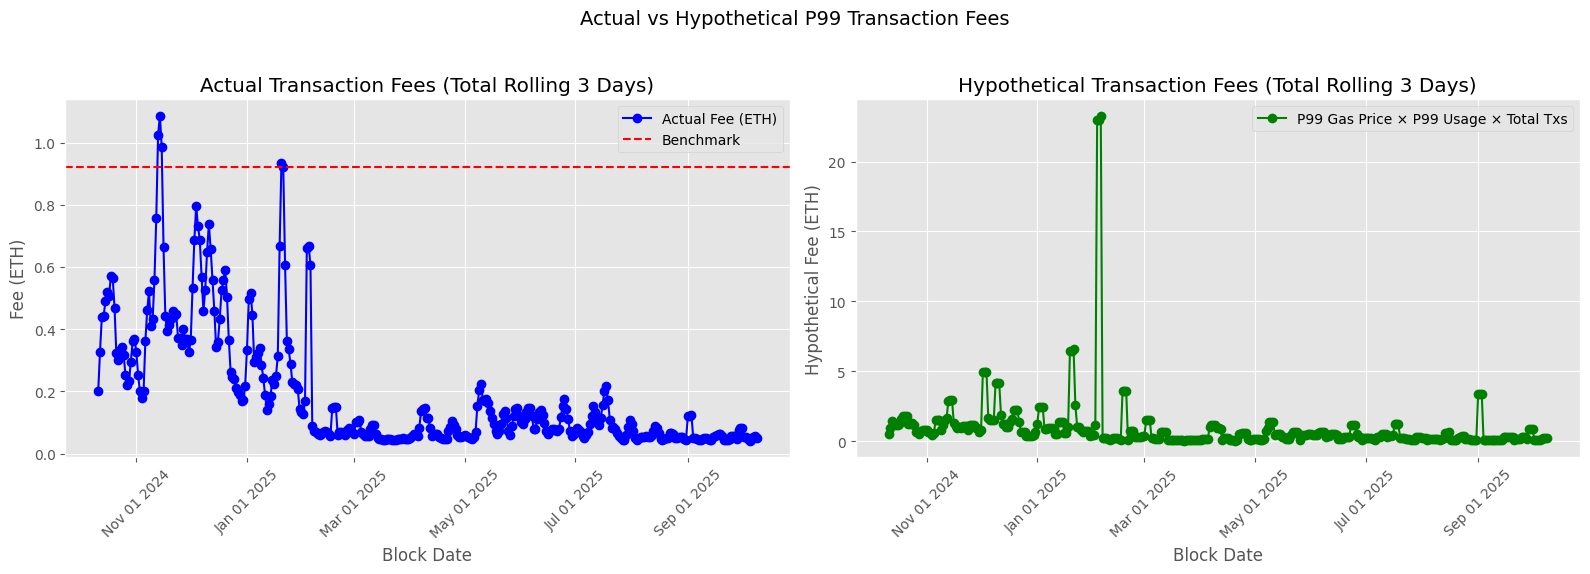

In [7]:
p99_actual = proposer_df["total_transaction_fee_in_eth"].quantile(0.99)

plot_actual_vs_modeled_fees(
    df=proposer_df.to_pandas(),
    block_date_col="block_date",
    actual_fee_col="total_transaction_fee_in_eth",
    modeled_fee_col="transaction_fee_in_eth_pct99",
    benchmark=p99_actual
)

In [8]:
def compute_policy(estimated_tx_fees_in_eth):
    refill_threshold = estimated_tx_fees_in_eth * 1.2
    top_up_target = refill_threshold * 1.5
    print(f"\n--- Top Up Recommendation for {int(TIME_INTERVAL) + 1} Day Window ---")
    print(f"Baseline Tx Fees:        {estimated_tx_fees_in_eth:.6f} ETH")
    print(f"Refill Threshold (X):      {refill_threshold:.6f} ETH")
    print(f"Top-Up Target (Y):         {top_up_target:.6f} ETH")
    return refill_threshold, top_up_target

def run_refill_simulation(df, daily_fee_col, refill_threshold, top_up_target):

    df = df.sort_values("block_date").copy()
    df["block_date"] = pd.to_datetime(df["block_date"])

    start_balance = []
    end_balance = []
    eth_topped_up = []
    insufficient_funds = []

    # Initial state
    prev_balance = top_up_target
    total_topped_up = 0
    refill_count = 0

    for fee in df[daily_fee_col]:
        start_balance.append(prev_balance)

        # Spend fee
        post_fee_balance = max(prev_balance - fee, 0)
        insufficient_funds.append(fee > prev_balance)

        # Refill if below threshold
        if post_fee_balance < refill_threshold:
            refill_amt = top_up_target - post_fee_balance
            post_fee_balance += refill_amt
            eth_topped_up.append(refill_amt)
            refill_count += 1
        else:
            eth_topped_up.append(0)

        end_balance.append(post_fee_balance)
        prev_balance = post_fee_balance  # carry forward

    df["start_balance"] = start_balance
    df["end_balance"] = end_balance
    df["eth_topped_up"] = eth_topped_up
    df["insufficient_funds"] = insufficient_funds

    summary = {
        "refill_threshold": refill_threshold,
        "top_up_target": top_up_target,
        "total_top_ups": refill_count,
        "occurrences_of_insufficient_funds": sum(insufficient_funds),
        "final_balance": end_balance[-1]
    }

    return df, summary

def plot_refill_simulation(df, fee_col="daily_transaction_fee_in_eth"):
    plt.figure(figsize=(14, 6))

    # Plot end-of-day wallet balance
    plt.plot(df["block_date"], df["end_balance"], label="End-of-Day Balance", color='blue', marker='o')

    # Plot actual daily transaction fees
    plt.plot(df["block_date"], df[fee_col], label="Daily Fee Spent", color='gray', linestyle='--', marker='x')

    # Highlight top-up events (eth_topped_up > 0)
    refill_df = df[df["eth_topped_up"] > 0]
    plt.scatter(refill_df["block_date"], refill_df["eth_topped_up"],
                color='orange', label="Top-Up Event & Amount", zorder=5, s=80)

    # Plot formatting
    plt.title("Wallet Refill Simulation")
    plt.xlabel("Block Date")
    plt.ylabel("ETH")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
# Use actual 99th percentile of transaction fees
refill_threshold, top_up_target = compute_policy(p99_actual)

# # Use hypothetical 99th gas price and usage
# p99_hypothetical = proposer_df["transaction_fee_in_eth_pct99"].quantile(0.99)
# refill_threshold, top_up_target = compute_policy(p99_hypothetical)


--- Top Up Recommendation for 3 Day Window ---
Baseline Tx Fees:        0.921633 ETH
Refill Threshold (X):      1.105959 ETH
Top-Up Target (Y):         1.658939 ETH


In [10]:
output_df, summary = run_refill_simulation(proposer_df.to_pandas(), "daily_transaction_fee_in_eth", refill_threshold, top_up_target)
summary

{'refill_threshold': 1.1059593202625988,
 'top_up_target': 1.658938980393898,
 'total_top_ups': 36,
 'occurrences_of_insufficient_funds': 0,
 'final_balance': 1.4140577174799187}

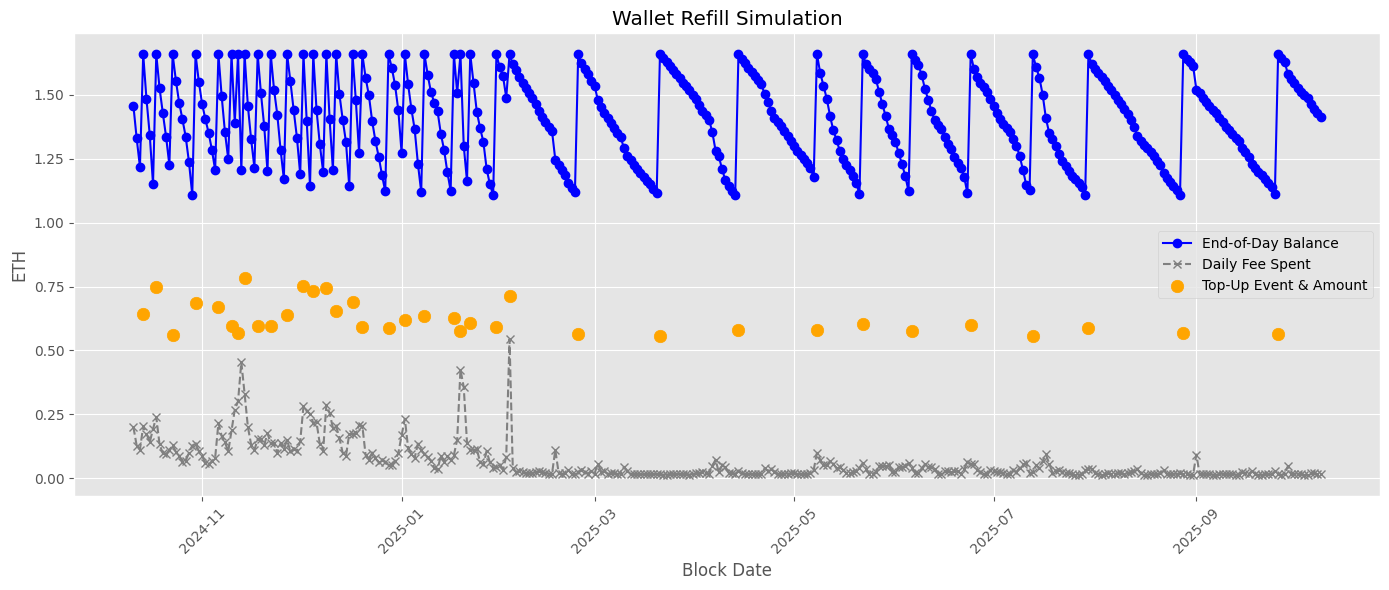

In [12]:
plot_refill_simulation(output_df)

## Batcher

In [22]:
batcher_df = spice.query(5939705, parameters={
    'Address': BATCHER_ADDRESS,
    'Time Interval': TIME_INTERVAL,
    'Trailing Days': TRAILING_DAYS
}, performance="large")

loading result from cache


In [25]:
batcher_df = batcher_df.with_columns([
    pl.col("avg_gas_used").cast(pl.Float64),
    pl.col("max_gas_used").cast(pl.Float64),
    pl.col("pct99_gas_used").cast(pl.Float64),
])

batcher_df.head()

block_date,daily_transaction_fee_in_eth,daily_blob_fee_in_eth,daily_all_fees_in_eth,total_transaction_fee_in_eth,total_blob_fee_in_eth,total_all_fees,total_value_in_eth,total_txs,avg_seconds_between_txs,avg_gas_price_in_gwei,max_gas_price_in_gwei,pct99_gas_price_in_gwei,avg_gas_used,max_gas_used,pct99_gas_used,avg_blob_base_fee,max_blob_base_fee,pct99_blob_base_fee,avg_blob_gas_used,max_blob_gas_used,pct99_blob_gas_used
str,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,i64,i64
"""2025-10-09""",0.048284,0.000341,0.048625,0.092546,0.000341,0.092887,0,1016,254.893701,4.337562,34.583513,21.190931,21000.0,21000.0,21000.0,426890.187992,23841334,1.6965106e7,784238.866142,786432,786432
"""2025-10-08""",0.017402,2.5494e-10,0.017402,0.076254,1.8322e-8,0.076254,0,847,306.063754,4.287061,34.583513,19.10453,21000.0,21000.0,21000.0,27.510035,1268,563.0,783801.275089,786432,786432
"""2025-10-07""",0.02686,9.6181e-10,0.02686,0.084243,0.001151,0.085394,0,931,278.758324,4.308909,34.583513,18.822664,21000.0,21000.0,21000.0,1.5720e6,100583805,4.5868151e7,786432.0,786432,786432
"""2025-10-06""",0.031992,1.7106e-8,0.031992,0.088139,0.001151,0.08929,0,1259,206.01112,3.333673,18.468566,17.489796,21000.0,21000.0,21000.0,1.1624e6,100583805,4.3528809e7,786432.0,786432,786432
"""2025-10-05""",0.025392,0.001151,0.026543,0.081619,0.001151,0.08277,0,1378,187.959361,2.820476,19.044784,11.122392,21000.0,21000.0,21000.0,1.0620e6,100583805,4.2224e7,786432.0,786432,786432


In [26]:
batcher_df = batcher_df.with_columns(
    (
        pl.col("pct99_gas_price_in_gwei") / 1e9 * pl.col("pct99_gas_used") * pl.col("total_txs")
    ).alias("transaction_fee_in_eth_pct99")
)

batcher_df = batcher_df.with_columns(
    (
        pl.col("pct99_blob_base_fee") * pl.col("pct99_blob_gas_used")/ 1e18 * pl.col("total_txs")
    ).alias("blob_fee_in_eth_pct99")
)

batcher_df = batcher_df.with_columns(
    (
        pl.col("transaction_fee_in_eth_pct99") + pl.col("blob_fee_in_eth_pct99")
    ).alias("total_all_fees_pct99")
)


In [27]:
batcher_df.describe()

statistic,block_date,daily_transaction_fee_in_eth,daily_blob_fee_in_eth,daily_all_fees_in_eth,total_transaction_fee_in_eth,total_blob_fee_in_eth,total_all_fees,total_value_in_eth,total_txs,avg_seconds_between_txs,avg_gas_price_in_gwei,max_gas_price_in_gwei,pct99_gas_price_in_gwei,avg_gas_used,max_gas_used,pct99_gas_used,avg_blob_base_fee,max_blob_base_fee,pct99_blob_base_fee,avg_blob_gas_used,max_blob_gas_used,pct99_blob_gas_used,transaction_fee_in_eth_pct99,blob_fee_in_eth_pct99,total_all_fees_pct99
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""364""",364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0,364.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,0.062912,0.449876,0.512789,0.188424,1.349627,1.538051,0.0,690.945055,403.096633,8.208004,50.921506,34.136781,37382.846769,419148.857143,373512.659341,3.6105e9,9.1311e10,4.6161e10,704631.799441,711533.714286,711533.714286,7.396423,17.493315,24.889738
"""std""",null,0.111267,0.987782,1.048879,0.240376,2.298107,2.455111,0.0,230.377932,95.350953,7.309296,80.920203,43.435855,50364.104287,776128.985531,736601.648095,5.9585e9,1.6700e11,1.0013e11,71502.8338,64953.100783,64953.100783,20.019942,41.150634,50.117042
"""min""","""2024-10-11""",0.007186,1.0748e-10,0.00719,0.023799,1.8547e-10,0.028524,0.0,283.0,132.386108,2.393946,5.706702,4.351216,21000.0,21000.0,21000.0,1.0,1.0,1.0,541706.20598,655360.0,655360.0,0.04639,1.8547e-10,0.054647
"""25%""",null,0.015198,2.1234e-10,0.020884,0.054884,6.6768e-10,0.07326,0.0,542.0,338.490862,3.362331,19.044784,10.851131,21000.0,21000.0,21000.0,1.00411,2.0,1.0,654361.35619,655360.0,655360.0,0.203091,8.9417e-10,0.294662
"""50%""",null,0.027745,0.000202,0.050608,0.096855,0.179326,0.320781,0.0,618.0,419.436893,4.968871,35.284847,22.883493,21000.0,21000.0,21000.0,4.4931e8,8.7225e9,6.3714e9,655360.0,655360.0,655360.0,0.434461,2.718457,2.988154
"""75%""",null,0.060306,0.481146,0.529305,0.226553,1.862504,2.075481,0.0,764.0,477.874539,9.847646,51.695576,38.028375,21000.0,21000.0,21000.0,4.9123e9,1.0348e11,5.1042e10,785779.250996,786432.0,786432.0,0.93179,18.857281,31.28097
"""max""","""2025-10-09""",1.097538,10.978706,11.108561,1.957643,15.987516,16.28498,0.0,1958.0,614.900474,40.080653,829.262295,383.670034,340634.704319,1.932656e6,1.930788e6,3.5253e10,1.0492e12,8.6216e11,786432.0,786432.0,786432.0,197.083417,390.999269,392.176581


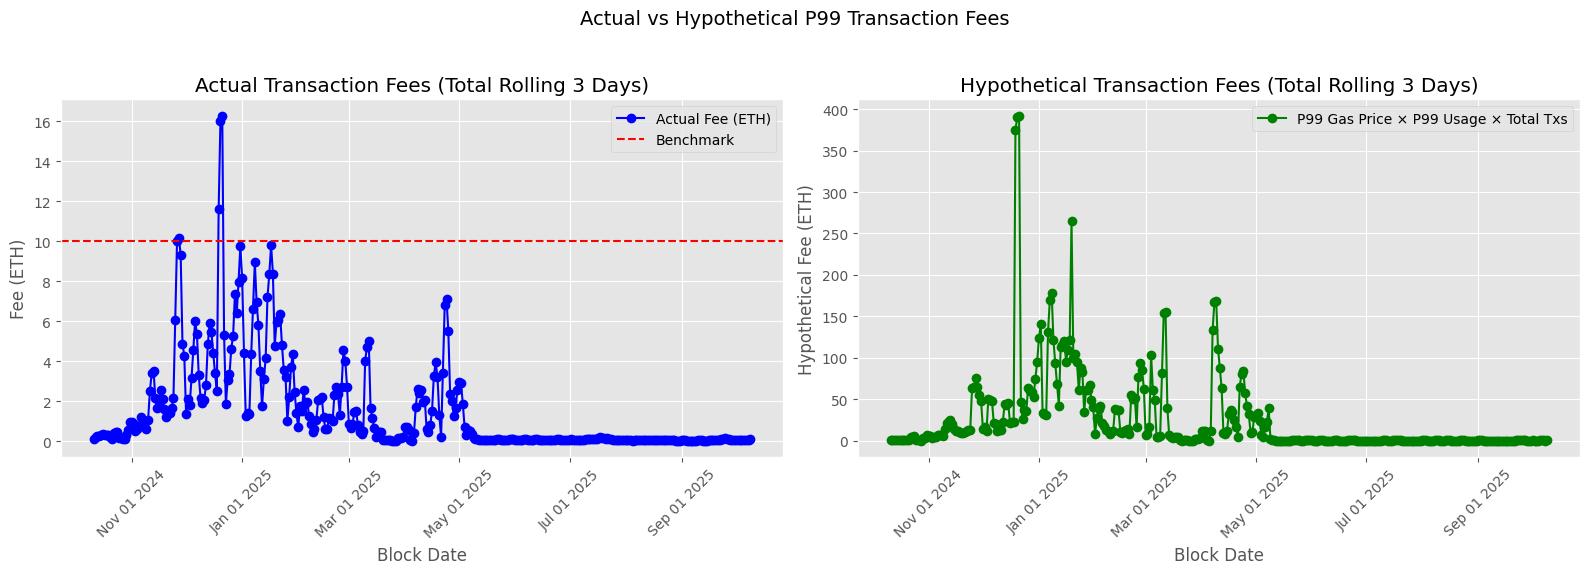

In [28]:
p99_actual = batcher_df["total_all_fees"].quantile(0.99)

plot_actual_vs_modeled_fees(
    df=batcher_df.to_pandas(),
    block_date_col="block_date",
    actual_fee_col="total_all_fees",
    modeled_fee_col="total_all_fees_pct99",
    benchmark=p99_actual
)

In [29]:
refill_threshold, top_up_target = compute_policy(p99_actual)



--- Top Up Recommendation for 3 Day Window ---
Baseline Tx Fees:        10.031425 ETH
Refill Threshold (X):      12.037710 ETH
Top-Up Target (Y):         18.056565 ETH


In [40]:
output_df, summary = run_refill_simulation(batcher_df.to_pandas(), "daily_all_fees_in_eth", refill_threshold, top_up_target)
summary

{'refill_threshold': 12.037709993618613,
 'top_up_target': 18.05656499042792,
 'total_top_ups': 25,
 'occurrences_of_insufficient_funds': 0,
 'final_balance': 16.071692284982085}

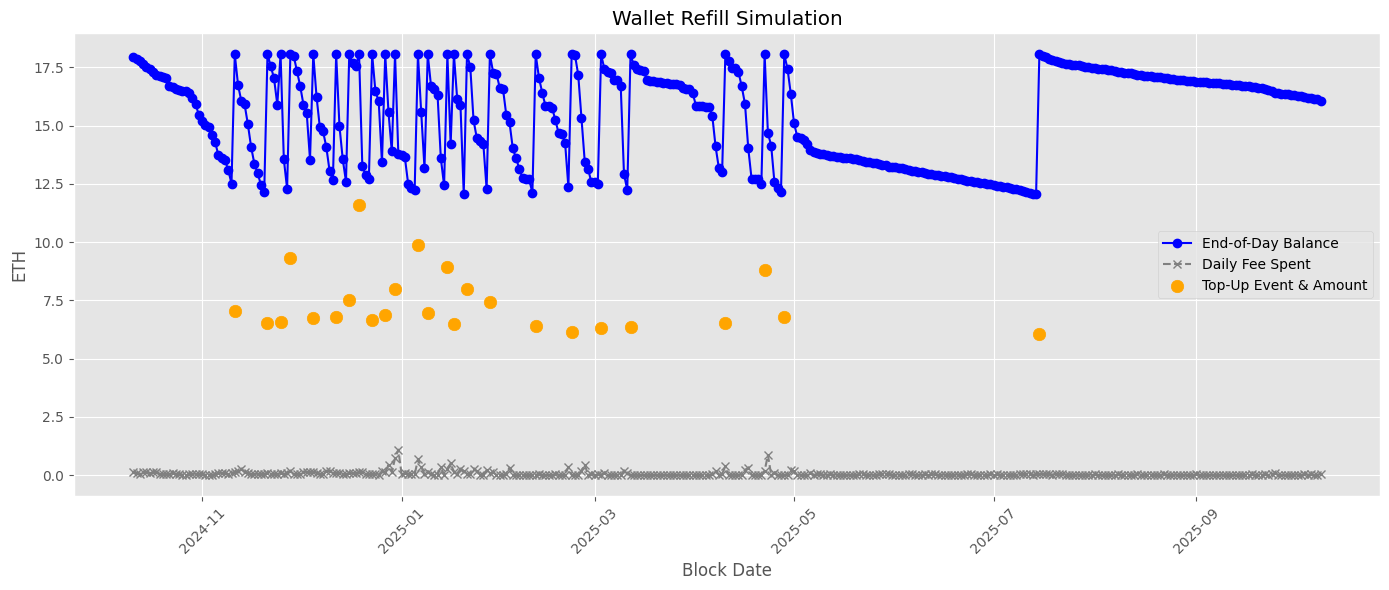

In [41]:
plot_refill_simulation(output_df)